### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import load_model

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


In [3]:
!nvidia-smi
# !kill -9 <PID>

Wed Apr  2 22:30:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   49C    P0             66W /  250W |   17957MiB /  40960MiB |     22%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Data Preprocessing

In [4]:
wind_cols = ['uSq','Z2','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df2 = pd.read_csv('Data_1973_2004.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_retrain: [2007-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_retrain = df1[(df1.index > split1) & (df1.index < split3)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

### Data Preparation

In [5]:
time_step = 6
features_1 = ['scaled_H'] + scaled_wind_cols
features_2 = ['Spike'] + scaled_wind_cols
features_s = features_1 + ['H_pred','Spike_pred']

# Create sequences using the retraining set
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

X_retrain1, y_retrain1 = create_sequences(df_retrain[features_1].values, time_step)
X_retrain2, y_retrain2 = create_sequences(df_retrain[features_2].values, time_step)
X_retrains, y_retrains = create_sequences(df_retrain[features_s].values, time_step)

### Model Retraining & Deployment

In [6]:
epochs = 50
batch_size = 64
model_file1 = 'best_model_1.keras'
model_file2 = 'best_model_2.keras'
model_files = 'best_model_s.keras'
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

I0000 00:00:1743647446.397393 2904159 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
I0000 00:00:1743647449.152768 2904400 cuda_dnn.cc:529] Loaded cuDNN version 90300


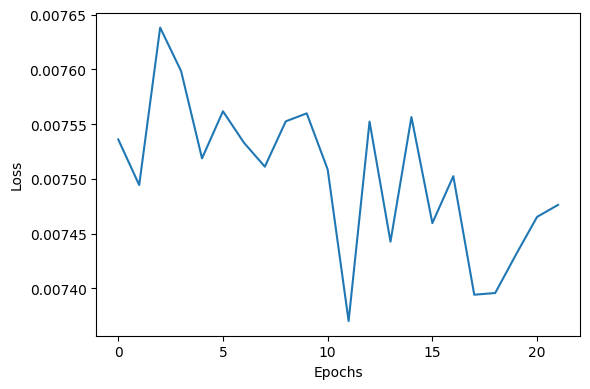

In [7]:
# Retrain model-1
model_1 = load_model(model_file1)
history_1 = model_1.fit(X_retrain1, y_retrain1, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
model_1.save(model_file1)

# Plot the training loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history_1.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [8]:
# Deploy model-1
df2['scaled_H'] = np.nan
X, _ = create_sequences(df2[features_1].values, time_step)

# Add predicted wave heights
df2['H_pred'] = 0.0
df2.loc[df2.index[time_step:], 'H_pred'] = model_1.predict(X, verbose=0).flatten()

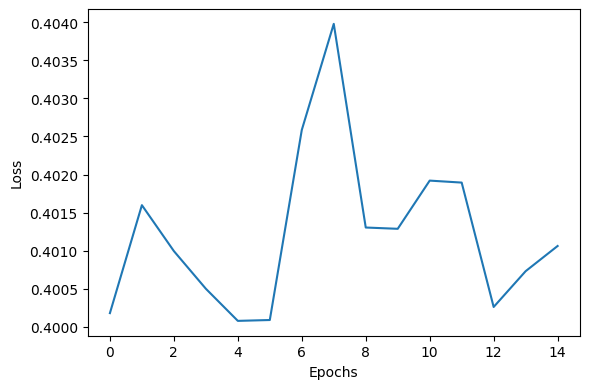

In [9]:
# Retrain model-2
model_2 = load_model(model_file2)
history_2 = model_2.fit(X_retrain2, y_retrain2, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
model_2.save(model_file2)

# Plot the training loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history_2.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [10]:
# Deploy model-2
df2['Spike'] = np.nan
X, _ = create_sequences(df2[features_2].values, time_step)

# Add predicted spikes
df2['Spike_pred'] = 0.0
df2.loc[df2.index[time_step:], 'Spike_pred'] = model_2.predict(X, verbose=0).flatten()

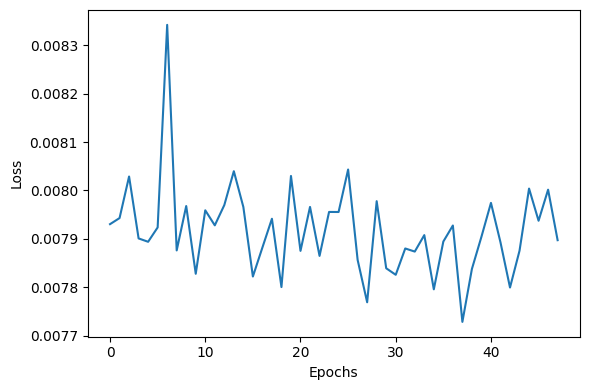

In [11]:
# Retrain model-s
model_s = load_model(model_files)
history_s = model_s.fit(X_retrains, y_retrains, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
model_s.save(model_files)

# Plot the training loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history_s.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [12]:
# Deploy model-s
X, _ = create_sequences(df2[features_s].values, time_step)
y_pred = model_s.predict(X, verbose=0)
y_pred_raw = scaled_wave.inverse_transform(y_pred)

# Add predicted wave heights
df2['SWHft'] = 0.0
df2.loc[df2.index[time_step:], 'SWHft'] = y_pred_raw.flatten()

# Save to CSV
df2 = df2.drop(['scaled_H','H_pred','Spike','Spike_pred'], axis=1)
df2.to_csv('Data_1973_2004.csv')

df2.head(10)

,uSq,Z2,Z4,scaled_uSq,scaled_Z2,scaled_Z4,SWHft
TimeStamp_1,,,,,,,
1973-11-01 00:00:00,84.476135,1165.979518,222128.707649,0.203203,0.256944,0.007747,0.000000
1973-11-01 01:00:00,72.305431,1078.721566,240096.732733,0.173217,0.234647,0.008772,0.000000
1973-11-01 02:00:00,84.476135,1165.979518,222128.707649,0.203203,0.256944,0.007747,0.000000
1973-11-01 03:00:00,77.720269,1118.384272,231581.872272,0.186558,0.244782,0.008286,0.000000
1973-11-01 04:00:00,84.476135,1165.979518,222128.707649,0.203203,0.256944,0.007747,0.000000
1973-11-01 05:00:00,84.476135,1165.979518,222128.707649,0.203203,0.256944,0.007747,0.000000
1973-11-01 06:00:00,72.305431,1078.721566,240096.732733,0.173217,0.234647,0.008772,1.560800
1973-11-01 07:00:00,48.163739,880.408038,294178.962794,0.113738,0.183973,0.011857,1.751204
1973-11-01 08:00:00,90.321074,1205.642224,214821.211816,0.217604,0.267079,0.007330,1.963039


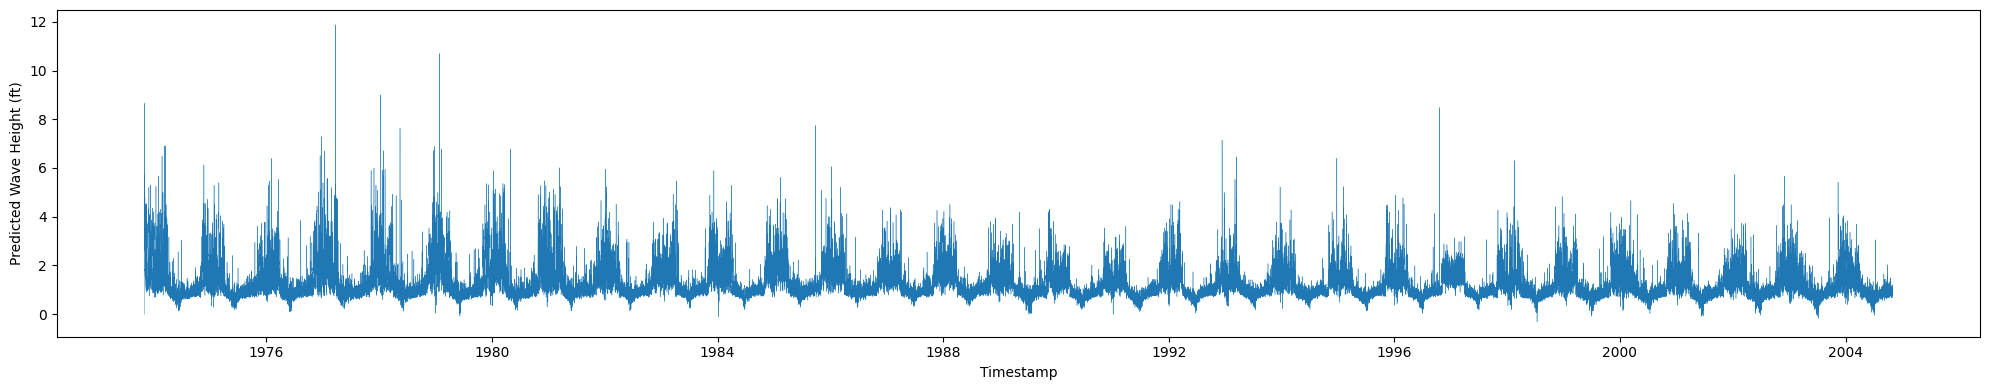

In [13]:
plt.figure(figsize=(20, 4))
plt.plot(df2.index, df2['SWHft'], linewidth=0.3)

plt.xlabel('Timestamp')
plt.ylabel('Predicted Wave Height (ft)')

plt.tight_layout()
plt.show()